In [2]:
!pip install geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.4 MB/s eta 0:00:00a 0:00:01


In [157]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import pyrosm
import matplotlib.pyplot as plt
import contextily as cx 
import pandana
import geocoder
from shapely.geometry import LineString, Point
from IPython import display
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from pyproj import Proj, transform


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

'1.1.2'

In [158]:

ox.settings.use_cache=False 

ox.settings.use_cache=True
ox.settings.log_console=False

### Localising potential pubcrawl locations with the tags 'pub' and 'bar'
- 603 bars/pubs

In [159]:
tags = {'amenity': ['pub', 'bar']}
pubs = ox.geometries_from_place(["Copenhagen Municipality", "Frederiksberg Municipality"], tags=tags)

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


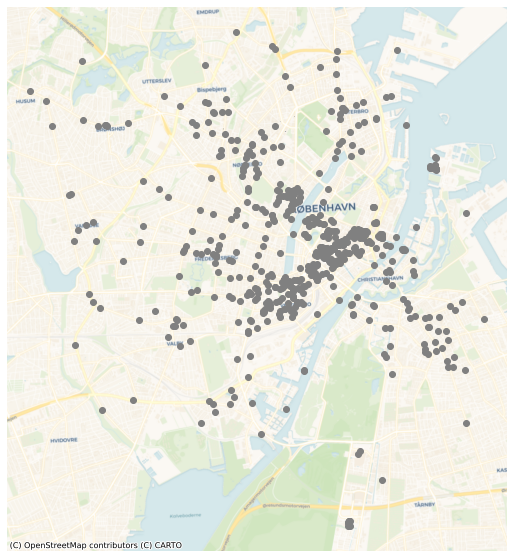

In [160]:
fig, ax = plt.subplots(figsize=(10,10))

pubs.to_crs("EPSG:25832").plot(ax=ax, color='grey')
ax.set_axis_off()
cx.add_basemap(
    ax=ax, 
    crs="EPSG:25832", 
    source=cx.providers.CartoDB.Voyager);

In [163]:
pubs
len(pubs.columns.to_list())

108

# Creating pubcrawl route

In [162]:
#Function takes the start position and find the nearest pub that is not in 'visited'
def make_route(start, pubs, visited, G_projected):

    routes = []
    route_times = []
    names = [(idx, name) for idx, name in enumerate(pubs.index)]
    bar_nodes = []
    # loop through all bars to find the nearest
    for idx, i in enumerate(pubs.geometry):

        bar_id = ox.nearest_nodes(G=G_projected, Y = i.y, X = i.x)
        bar_nodes.append((idx, bar_id))

        route = ox.shortest_path(G_projected, start, bar_id)
        routes.append(route)
        if bar_id in visited: 
            route_time = 10000
        else:
            route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_projected, route, "travel_time")))
        route_times.append((route_time,idx))
        
    #sort by travel time and selecting the shortest
    route_times.sort()  
    idx = route_times[0][1] 
    
    #returning route, node, travel_time and name of bar
    return routes[idx], bar_nodes[idx][1], route_times[0][0], names[idx][1]

In [154]:
def pubcrawl_route(start_address, no_bars, network_type = "walk", time_spent):
    address_point =  ox.geocode(start_address)

    #find all pubs in area
    tags = {'amenity': ['pub', 'bar']}
    pubs = ox.geometries_from_point(address_point, tags=tags, dist=2000)
    
    #Making a copy of pubs with original lat long values to be used for plotting. (epsg:25823 does not work with Folium)
    pubs_plot = pubs.to_crs('EPSG:4326')
    pubs_plot.geometry = pubs_plot.centroid
    
    #polygons to points, by extracting the centroids
    pubs = pubs.to_crs('EPSG:25832')
    pubs = pubs.set_index('name')[['geometry']]
    pubs.geometry = pubs.centroid
        

    #create a network from input address
    G = ox.graph_from_address(
    address=start_address,
    dist=2000,
    dist_type="network",
    network_type= network_type)
    
    
    address_node = ox.nearest_nodes(G=G, Y = address_point[0], X = address_point[1])
    
    #adding speed depending on network
    if network_type == "walk":  
        speed = 5  # km per hour
    if network_type == "bike":  
        speed = 15  # km per hour
    for u, v, data in G.edges(data=True):
        data['speed_kph'] = speed
    G = ox.add_edge_travel_times(G)
    

    G_projected = ox.project_graph(G, to_crs='EPSG:25832')
    
    start = address_node
    pub_crawl = []
    visited = []
    travel_time = 0
    names = []
    # find route by selected the nearest bar from start point
    for i in range(no_bars):
        route, bar, time, name = make_route(start, pubs, visited, G_projected)
        start = bar
        pub_crawl.append(route)
        visited.append(bar)
        travel_time += time
        names.append(name)
        
    selected_pubs = pubs_plot.query('name in @names')
    plot = plot_route(G, pub_crawl, address_point, selected_pubs)
    total_time = travel_time + time_spent*no_bars
    return plot, 



In [155]:
### Plotting pubcrawl route with Folium
def plot_route(G, pub_crawl, address_point, selected_pubs):
    
    basemaps = {
        'st_water': folium.TileLayer(
        tiles = 'https://stamen-tiles.a.ssl.fastly.net/watercolor/{z}/{x}/{y}.jpg',
        attr = 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
        name = 'Stamen Watercolor',
        overlay = True,
        control = True,
        opacity = 1),
    'st_lite': folium.TileLayer(
        tiles = 'https://stamen-tiles.a.ssl.fastly.net/toner-labels/{z}/{x}/{y}.png',
        attr = 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
        name = 'Background: Stamen',
        overlay = True,
        control = True,
        opacity = 1),
    }
    loc = 'Pubcrawl Route'
    title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format(loc) 
    
    # create a map object
    m = folium.Map(location = [address_point[0], address_point[1]], zoom_start = 15.5, tiles = "OpenStreetMap") 
    
    # creating pub/bars markers
    for pub, row in selected_pubs.iterrows():
        
        name = str(row["name"])
        website = row["website"]
        opening_hours = row["opening_hours"]
        
        tooltip = str(row["name"])
        
        pop_html = folium.Html(f"""<p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 21px;">{name}</span></p>
        <p style="text-align: center;"><a href={website} target="_blank" title="{website} Website"><span style="font-family: Didot, serif; font-size: 17px;">{website}</span></a></p>
        <p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 17px;">Opening Hours: <br> {opening_hours}</span></a></p>
        """, script=True)
        
        iframe = folium.IFrame( pop_html)
        #Initialise the popup using the iframe
        popup = folium.Popup(iframe, min_width=300, max_width=300)
        folium.Marker([row["geometry"].y,  row["geometry"].x], popup=popup, tooltip=tooltip, 
                      icon=folium.Icon(color='black' , prefix='fa', icon="beer")).add_to(m)
    # start marker
    folium.Marker([address_point[0], address_point[1]], tooltip="Start", icon=folium.Icon(color='green' , prefix='fa', icon="home")).add_to(m)


    # add watercolor and label layer
    for key, value in basemaps.items():
        value.add_to(m)

    # create a "feature group" for the whole network:
    mnw = folium.FeatureGroup(name = "Street network", show = True)

    # initialize list of coordinates (to pass to PolyLine)
    mloc = []

    # get coordinates of all edges
    for edge in G.edges:
        if "geometry" in G.edges[edge].keys():
            loc = [(c[1], c[0]) for c in G.edges[edge]["geometry"].coords]
            mloc.append(loc)
        # if edge was not simplified - get coordinates through nodes:
        else:
            loc = []
            for node in edge[:-1]:
                loc.append((G.nodes[node]["y"], G.nodes[node]["x"]))  
            mloc.append(loc)

    # create a "PolyLine" of all edges and add it to the "mnw" FeatureGroup:
    my_polyline = folium.PolyLine(locations = mloc, weight = 1, color = "gray").add_to(mnw)

    # Add the feature group to the map:
    mnw.add_to(m)
    
    #add title to the map:
    m.get_root().html.add_child(folium.Element(title_html))

    # plotting the route between bars: 
    r1 = folium.FeatureGroup(name = "Route", show = True)
    rloc = []
    for route in pub_crawl:
        for node in route:
            rloc.append((G.nodes[node]["y"], G.nodes[node]["x"]))
    my_polyline = folium.PolyLine(locations = rloc, weight = 5, color = "green").add_to(r1)
    r1.add_to(m)



    ### Layer control    
    folium.LayerControl().add_to(m)

    m.save("pubcrawl_lab.html")
    return 

In [165]:
pub_crawl = pubcrawl_route("Langebrogade 1A, 1411 København K", 4, "walk")

/tmp/ipykernel_103/4096876870.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pubs_plot.geometry = pubs_plot.centroid
